In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.io
import os
import math
from scipy.io import loadmat
from scipy.signal import butter,filtfilt,resample
from biosppy import storage
from biosppy.signals import ecg
from hrvanalysis import get_time_domain_features,get_frequency_domain_features,get_geometrical_features,get_poincare_plot_features


In [3]:
def load_data(header_file):
    with open(header_file, 'r') as f:
        header = f.readlines()
    mat_file = header_file.replace('.hea', '.mat')
    x = loadmat(mat_file)
    recording = np.asarray(x['val'], dtype=np.float64)
    return recording, header

def butter_lowpass(cutoff, sample_rate, order=2):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass(cutoff, sample_rate, order=2):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a


def butter_bandpass(lowcut, highcut, sample_rate, order=2):
    nyq = 0.5 * sample_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def filter_signal(data, cutoff, sample_rate, order=2, filtertype='lowpass',
                  return_top = False):

    if filtertype.lower() == 'lowpass':
        b, a = butter_lowpass(cutoff, sample_rate, order=order)
    elif filtertype.lower() == 'highpass':
        b, a = butter_highpass(cutoff, sample_rate, order=order)
    elif filtertype.lower() == 'bandpass':
        assert type(cutoff) == tuple or list or np.array, 'if bandpass filter is specified, \
cutoff needs to be array or tuple specifying lower and upper bound: [lower, upper].'
        b, a = butter_bandpass(cutoff[0], cutoff[1], sample_rate, order=order)
    elif filtertype.lower() == 'notch':
        b, a = iirnotch(cutoff, Q = 0.005, fs = sample_rate)
    else:
        raise ValueError('filtertype: %s is unknown, available are: \
lowpass, highpass, bandpass, and notch' %filtertype)

    filtered_data = filtfilt(b, a, data)
    
    if return_top:
        return np.clip(filtered_data, a_min = 0, a_max = None)
    else:
        return filtered_data


In [134]:
def waveletH(w):
    return np.exp(1j*w/2) * np.cos(w/2) ** 3
    
def waveletG(w):
   
    return 4j*np.exp(1j*w/2)*np.sin(w/2)

def waveletFilters(N,fs):
    
    # M is the number of samples at 250 Hz that will produce N samples after 
    # re-sampling the filters    
#     M =  N* 250/fs
    w = np.arange(0,2*np.pi, 2*np.pi/N) # Frequency axis in radians
    
    # Construct the filters at 250 Hz as specified in the paper
#     Q = [waveletG(w)]    
    for k in range(2,5):
        G = waveletH(w)
        for l in range(1,k-1):
            G *= waveletH(2**l * w)
        Q = waveletG(2 ** (k-1) * w) * G ###hhhg
        P = waveletH(2 ** (k-1) * w) * G   ###hhhh
        
    # Resample the filters from 250 Hz to the desired sampling frequency
#     for i in range(len(Q)):
#     Q = np.fft.fft(resample(np.fft.ifft(Q),N))
#     print(P,Q)
    return [P,Q]    
    
def waveletDecomp(sig,Q):
    w = []
#     print(len(Q))
#     print(Q)
    # Apply the filters in the frequency domain and return the result in the time domain
    for q in Q:
#         print(len(q)) 
        w += [np.real(np.fft.ifft(np.fft.fft(sig) * q))]
#     print(len(w))
    return w

In [228]:
def func():
    ##read data

    header_files = []
    input_directory=r'C:\Users\ayant\Documents\BTP\Training_WFDB'
    for f in os.listdir(input_directory):
        g = os.path.join(input_directory, f)
        if not f.lower().startswith('.') and f.lower().endswith('hea') and os.path.isfile(g):
            header_files.append(g)
            
    header_files = header_files
    headers=[]
    labels = []
    for i in header_files:
        subject=i.split('\\')[-1]
        headers.append(subject.split('.')[0])
    d = {}
    a = {}
    c = 0
#     features_hrv=list()
#     headers = headers[:1000]
    for i in header_files:
        h = load_data(i)
        lead_II_ecg=h[0][1]
        labels.append(h[1][15].split(':')[1])
        fs = int(h[1][0].split(' ')[2])
        beg = int(np.floor(900))
        end = int(np.floor(4000))
        sigg = lead_II_ecg[beg:end]
        N = sigg.shape[0]
        t = np.arange(0,N/fs,1/fs)
        sig = filter_signal(data = sigg, cutoff = [0.9, 20], sample_rate = fs, filtertype='bandpass')
        ecg_signal=sig-np.mean(sig)
        try:
            out = ecg.ecg(signal=ecg_signal, sampling_rate=fs, show=False)
            R=out[2]

            win1 = 50
            R_peak = []
            for j in range(len(R)):
                if R[j] - win1<0:
                    R_peak.append(np.argmax(np.abs(ecg_signal[:R[j]+win1]))+R[j]-win1)
                elif R[j]+win1>=len(ecg_signal):
                    R_peak.append(np.argmax(np.abs(ecg_signal[R[j]-win1:]))+R[j]-win1)
                else:
                    R_peak.append(np.argmax(np.abs(ecg_signal[R[j]-win1:R[j]+win1]))+R[j]-win1)

            R_val=np.empty((len(R_peak),))
            for k in range(len(R_peak)):
                R_val[k]=ecg_signal[R_peak[k]]

            R_one = R_peak[len(R_peak)//2]

            try:
                ecg_ = ecg_signal[R_one-99:R_one+101]
            except:
                ecg_ = ecg_signal[:100]
        except:
            ecg_  = ecg_signal[:200]
            R_one = 99
            r_val = ecg_signal[99]
        
#         plt.figure(figsize=(20,5))
#         plt.plot(t,ecg_signal,label='ECG')
#         plt.plot(t[R_peak],R_val,'o',c='r',markeredgewidth=1.5,label='Detected R Peaks')
#         plt.legend(loc='lower left')
#         plt.xlabel('Time')
#         plt.ylabel('Normalized Amplitude')
#         plt.title('R peaks')
#         plt.xlim([0,t[N-1]])
#         plt.show()

#         t_ = t[R_one-99:R_one+101]
#         plt.figure(figsize=(20,5))
#         plt.plot(t_,ecg_,label='ECG')
#         plt.plot(t_[99],ecg_signal[R_one],'o',c='r',markeredgewidth=1.5,label='Detected R Peaks')
#         plt.legend(loc='lower left')
#         plt.xlabel('Time')
#         plt.ylabel('Normalized Amplitude')
#         plt.title('R peaks')
#         plt.show()
    
        N1 = ecg_.shape[0] # Number of samples in the signal
        Q = waveletFilters(N1,fs) # Create the filters to apply the algorithme-a-trous
        w= waveletDecomp(ecg_,Q)
        d[i[-9:-4]] = w[0]
        a[i[-9:-4]] = w[1]
        
#         print(c)
#         c+=1
    df_d = pd.DataFrame.from_dict(d, orient='index')
    df_a = pd.DataFrame.from_dict(a, orient='index')
    return df_d, df_a
        
        

In [229]:
df_d,df_a = func()

In [233]:
df_d

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
A0001,98.835499,95.612743,92.982459,90.846247,89.105102,87.660508,86.415557,85.276057,84.151619,82.956673,...,156.879707,150.258691,143.550690,136.866699,130.312334,123.987296,117.984952,112.392037,107.288495,102.747478
A0002,61.037748,63.399809,65.441346,67.127454,68.424946,69.303527,69.737024,69.704551,69.191495,68.190261,...,28.315062,31.796801,35.311024,38.833671,42.337299,45.791134,49.161264,52.410956,55.501090,58.390715
A0003,-74.915197,-74.176561,-72.964495,-71.294993,-69.187016,-66.662814,-63.748250,-60.473087,-56.871219,-52.980781,...,-69.146942,-69.732189,-70.472414,-71.317919,-72.214108,-73.101138,-73.913711,-74.580934,-75.026196,-75.167056
A0004,-31.847035,-36.155475,-40.272836,-44.142259,-47.718061,-50.965830,-53.862029,-56.393276,-58.555416,-60.352510,...,3.872971,1.928745,-0.503974,-3.393912,-6.700749,-10.374892,-14.357144,-18.578495,-22.960290,-27.414907
A0005,-42.994957,-43.308758,-42.270860,-39.962431,-36.476088,-31.914662,-26.389666,-20.019545,-12.927751,-5.240744,...,17.975793,9.258659,0.704702,-7.519844,-15.252200,-22.334568,-28.615591,-33.951693,-38.208257,-41.260635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A6873,21.650650,21.197773,20.384249,19.233493,17.768143,16.010394,13.982384,11.706630,9.206464,6.506439,...,9.265392,11.462530,13.529164,15.432267,17.140176,18.622345,19.849231,20.792292,21.424089,21.718443
A6874,-11.933709,-8.160867,-4.414381,-0.715422,2.911520,6.439301,9.838886,13.080189,16.132937,18.967544,...,-46.518651,-43.566849,-40.474016,-37.246601,-33.893126,-30.424550,-26.854540,-23.199623,-19.479226,-15.715613
A6875,60.737713,73.374217,85.019938,95.663047,105.289276,113.882784,121.427287,127.907466,133.310633,137.628603,...,-84.969839,-71.621937,-57.570529,-42.959402,-27.941798,-12.681310,2.647360,17.857857,32.751880,47.119167
A6876,22.337387,23.445276,24.317360,24.965452,25.401518,25.637558,25.685542,25.557393,25.264990,24.820212,...,-0.654392,2.417929,5.365482,8.166854,10.802979,13.257001,15.514104,17.561317,19.387313,20.982213


In [186]:
labels = pd.read_excel("labels.xlsx")

In [187]:
for i in range(len(labels)):
    labels["Subject"][i] = labels["Subject"][i][:-1]

In [189]:
labels.set_index('Subject')

,Class,Age,Sex
Subject,,,
A0001,RBBB,'74','Male'
A0002,Normal,'49','Female'
A0003,AF,'81','Female'
A0004,AF,'45','Male'
A0005,PVC,'53','Male'
...,...,...,...
A6873,I-AVB,'80','Male'
A6874,STD,'62','Female'
A6875,LBBB,'78','Male'


In [391]:
###PCA

from sklearn.decomposition import PCA
pca_comp1 = PCA(n_components=3)
principalComponents1 = pca_comp.fit_transform(df_d)
principal_Df1 = pd.DataFrame(data = principalComponents1
             , columns = ['principal component 11', 'principal component 12','principal component 13'])

In [392]:
x = pca_comp.explained_variance_ratio_

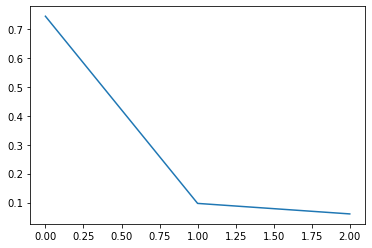

In [393]:
plt.plot(range(0,len(x)),x)

In [394]:
from sklearn.decomposition import PCA
pca_comp2 = PCA(n_components=3)
principalComponents2 = pca_comp.fit_transform(df_a)
principal_Df2 = pd.DataFrame(data = principalComponents2
             , columns = ['principal component 21', 'principal component 22','principal component 23'])

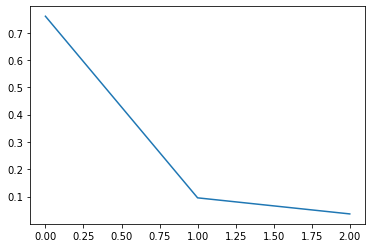

In [395]:
x = pca_comp.explained_variance_ratio_
plt.plot(range(0,len(x)),x)

In [396]:
principal_Df1

,principal component 11,principal component 12,principal component 13
0,-3013.528043,-213.817861,28.174429
1,-594.374764,1.357895,-40.322969
2,1064.087982,561.559551,-250.741571
3,189.837345,-125.355428,114.374952
4,-95.695756,-376.012495,-580.002438
...,...,...,...
6872,-702.552584,-91.161450,131.105754
6873,601.315768,66.805667,-92.849522
6874,2207.946903,247.242863,-951.618644
6875,-399.748546,299.916283,162.183812


In [429]:
df_pca=pd.concat([principal_Df1,principal_Df2],axis=1)

In [430]:
df_pca["labels"] = labels["Class"]

In [431]:
df_pca

,principal component 11,principal component 12,principal component 13,principal component 21,principal component 22,principal component 23,labels
0,-3013.528043,-213.817861,28.174429,-4072.163608,-407.136335,316.195460,RBBB
1,-594.374764,1.357895,-40.322969,-490.385220,-219.387952,-440.599478,Normal
2,1064.087982,561.559551,-250.741571,567.603851,421.684616,266.663609,AF
3,189.837345,-125.355428,114.374952,443.284714,-232.080031,-185.212640,AF
4,-95.695756,-376.012495,-580.002438,1234.960598,-799.822991,662.466738,PVC
...,...,...,...,...,...,...,...
6872,-702.552584,-91.161450,131.105754,-1006.596731,29.920289,-87.694597,I-AVB
6873,601.315768,66.805667,-92.849522,630.727986,344.627749,181.751296,STD
6874,2207.946903,247.242863,-951.618644,2703.602067,2397.965855,-875.875939,LBBB
6875,-399.748546,299.916283,162.183812,-1296.479209,273.681732,211.760225,AF


In [433]:
df_pca["labels"][78]

'AF,RBBB'

In [434]:
k = ["AF","LBBB","I-AVB","PVC","PAC"] 

In [435]:
lis = []
for i in range(len(df_pca)):
    if df_pca["labels"][i] in k:
        lis.append("Abnormal")
    else:
        lis.append(df_pca["labels"][i])
df_pca["Class"] = lis

In [436]:
df_normal = df_pca[df_pca["Class"] == "Normal"]
df_abnormal = df_pca[df_pca["Class"] == "Abnormal"]

In [437]:
df_normal

,principal component 11,principal component 12,principal component 13,principal component 21,principal component 22,principal component 23,labels,Class
1,-594.374764,1.357895,-40.322969,-490.385220,-219.387952,-440.599478,Normal,Normal
15,-173.325388,-180.579756,169.875529,-173.022719,-171.557568,401.206840,Normal,Normal
19,171.365386,-148.382659,29.837706,249.267034,103.411418,203.911323,Normal,Normal
28,323.481047,-204.684948,89.800126,451.760743,5.908177,436.906269,Normal,Normal
29,1125.392558,-427.011851,-47.059438,2246.302424,-195.155252,254.540732,Normal,Normal
...,...,...,...,...,...,...,...,...
6831,-268.567987,54.986293,-16.904679,-104.173983,-332.053689,-47.054440,Normal,Normal
6844,-1248.884190,221.780900,372.202348,-2839.368328,185.304560,450.424635,Normal,Normal
6845,797.060012,-167.029956,-542.597549,2364.046559,-343.912238,-629.371015,Normal,Normal
6852,-1522.043409,213.853686,608.149347,-3371.837434,191.317891,138.125517,Normal,Normal


In [438]:
df_abnormal

,principal component 11,principal component 12,principal component 13,principal component 21,principal component 22,principal component 23,labels,Class
2,1064.087982,561.559551,-250.741571,567.603851,421.684616,266.663609,AF,Abnormal
3,189.837345,-125.355428,114.374952,443.284714,-232.080031,-185.212640,AF,Abnormal
4,-95.695756,-376.012495,-580.002438,1234.960598,-799.822991,662.466738,PVC,Abnormal
6,427.015095,328.942933,-38.101428,18.885782,511.057002,77.701233,AF,Abnormal
8,-577.384286,177.665465,355.269312,-1458.315094,-21.708919,223.584364,AF,Abnormal
...,...,...,...,...,...,...,...,...
6868,-2957.163851,-171.728432,801.522185,-4298.241055,-554.877587,232.321081,AF,Abnormal
6872,-702.552584,-91.161450,131.105754,-1006.596731,29.920289,-87.694597,I-AVB,Abnormal
6874,2207.946903,247.242863,-951.618644,2703.602067,2397.965855,-875.875939,LBBB,Abnormal
6875,-399.748546,299.916283,162.183812,-1296.479209,273.681732,211.760225,AF,Abnormal


In [439]:
df2=pd.concat([df_normal,df_abnormal])

In [440]:
df2

,principal component 11,principal component 12,principal component 13,principal component 21,principal component 22,principal component 23,labels,Class
1,-594.374764,1.357895,-40.322969,-490.385220,-219.387952,-440.599478,Normal,Normal
15,-173.325388,-180.579756,169.875529,-173.022719,-171.557568,401.206840,Normal,Normal
19,171.365386,-148.382659,29.837706,249.267034,103.411418,203.911323,Normal,Normal
28,323.481047,-204.684948,89.800126,451.760743,5.908177,436.906269,Normal,Normal
29,1125.392558,-427.011851,-47.059438,2246.302424,-195.155252,254.540732,Normal,Normal
...,...,...,...,...,...,...,...,...
6868,-2957.163851,-171.728432,801.522185,-4298.241055,-554.877587,232.321081,AF,Abnormal
6872,-702.552584,-91.161450,131.105754,-1006.596731,29.920289,-87.694597,I-AVB,Abnormal
6874,2207.946903,247.242863,-951.618644,2703.602067,2397.965855,-875.875939,LBBB,Abnormal
6875,-399.748546,299.916283,162.183812,-1296.479209,273.681732,211.760225,AF,Abnormal


In [442]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC 
X2 = StandardScaler().fit_transform(df2.drop(["labels","Class"],axis = 1))
df3 = pd.DataFrame(X2)

In [443]:
df3

,0,1,2,3,4,5
0,-0.516494,0.027785,-0.369602,-0.280156,-0.317172,-1.062571
1,-0.210991,-0.286740,0.228119,-0.116228,-0.258874,0.817403
2,0.039109,-0.231079,-0.170093,0.101898,0.076271,0.376791
3,0.149480,-0.328412,0.000416,0.206493,-0.042571,0.897130
4,0.731328,-0.712759,-0.388758,1.133431,-0.287636,0.489859
...,...,...,...,...,...,...
3894,-2.230878,-0.271438,2.024271,-2.247036,-0.726081,0.440237
3895,-0.594986,-0.132158,0.117873,-0.546796,-0.013304,-0.274442
3896,1.516804,0.452858,-2.960964,1.369641,2.872975,-2.034658
3897,-0.375278,0.543917,0.206247,-0.696529,0.283804,0.394319


In [449]:
X_train, Xtest, y_train, ytest = train_test_split(df2.drop(["labels","Class"],axis = 1), df2["Class"],test_size=0.2, random_state=5)
RFC = RandomForestClassifier(n_estimators=300,min_samples_split=15).fit(X_train, y_train)
print ("\nRFC :: ABC :: ABC :: Train Accuracy :: ", accuracy_score(y_train, RFC.predict(X_train)))
print ("RFC :: ABC :: Test Accuracy  :: ", accuracy_score(ytest, RFC.predict(Xtest)))

X_train, Xtest, y_train, ytest = train_test_split(df3, df2["Class"],test_size=0.2, random_state=5)
RFC = RandomForestClassifier(n_estimators=300,min_samples_split=15).fit(X_train, y_train)
print ("\nRFC :: ABC :: ABC :: Train Accuracy :: ", accuracy_score(y_train, RFC.predict(X_train)))
print ("RFC :: ABC :: Test Accuracy  :: ", accuracy_score(ytest, RFC.predict(Xtest)))


RFC :: ABC :: ABC :: Train Accuracy ::  0.9208079512664316
RFC :: ABC :: Test Accuracy  ::  0.8012820512820513

RFC :: ABC :: ABC :: Train Accuracy ::  0.9224110291760179
RFC :: ABC :: Test Accuracy  ::  0.7974358974358975


In [450]:
X_train, Xtest, y_train, ytest = train_test_split(df2.drop(["labels","Class"],axis = 1), df2["Class"],test_size=0.2, random_state=5)
svm_model_linear = SVC(kernel = 'rbf', C = 10,gamma='auto').fit(X_train,y_train) 
print ("\nSVM :: Train Accuracy :: ", accuracy_score(y_train, svm_model_linear.predict(X_train)))
print ("SVM :: Test Accuracy  :: ", accuracy_score(ytest, svm_model_linear.predict(Xtest)))
# print ("SVM :: MCC :: ", matthews_corrcoef(ytest, svm_model_linear.predict(Xtest)))
# print(confusion_matrix(ytest, svm_model_linear.predict(Xtest)))




SVM :: Train Accuracy ::  1.0
SVM :: Test Accuracy  ::  0.7666666666666667


In [451]:
X_train, Xtest, y_train, ytest = train_test_split(df3, df2["Class"],test_size=0.2, random_state=5)
svm_model_linear = SVC(kernel = 'rbf', C = 10,gamma='auto').fit(X_train,y_train) 
print ("\nSVM :: Train Accuracy :: ", accuracy_score(y_train, svm_model_linear.predict(X_train)))
print ("SVM :: Test Accuracy  :: ", accuracy_score(ytest, svm_model_linear.predict(Xtest)))
# print ("SVM :: MCC :: ", matthews_corrcoef(ytest, svm_model_linear.predict(Xtest)))
# print(confusion_matrix(ytest, svm_model_linear.predict(Xtest)))


SVM :: Train Accuracy ::  0.8137223469060596
SVM :: Test Accuracy  ::  0.7974358974358975


In [452]:
df_pca

,principal component 11,principal component 12,principal component 13,principal component 21,principal component 22,principal component 23,labels,Class
0,-3013.528043,-213.817861,28.174429,-4072.163608,-407.136335,316.195460,RBBB,RBBB
1,-594.374764,1.357895,-40.322969,-490.385220,-219.387952,-440.599478,Normal,Normal
2,1064.087982,561.559551,-250.741571,567.603851,421.684616,266.663609,AF,Abnormal
3,189.837345,-125.355428,114.374952,443.284714,-232.080031,-185.212640,AF,Abnormal
4,-95.695756,-376.012495,-580.002438,1234.960598,-799.822991,662.466738,PVC,Abnormal
...,...,...,...,...,...,...,...,...
6872,-702.552584,-91.161450,131.105754,-1006.596731,29.920289,-87.694597,I-AVB,Abnormal
6873,601.315768,66.805667,-92.849522,630.727986,344.627749,181.751296,STD,STD
6874,2207.946903,247.242863,-951.618644,2703.602067,2397.965855,-875.875939,LBBB,Abnormal
6875,-399.748546,299.916283,162.183812,-1296.479209,273.681732,211.760225,AF,Abnormal


# Same no of Abnormal normal classes 

In [453]:
df_pca["labels"].unique()
# df = df.reset_index()
# df = df.drop(["index"], axis = 1)

array(['RBBB', 'Normal', 'AF', 'PVC', 'STD', 'LBBB', 'STE', 'I-AVB',
       'AF,RBBB', 'PAC', 'RBBB,STD', 'I-AVB,STE', 'LBBB,PVC', 'I-AVB,PVC',
       'AF,STD', 'RBBB,PAC', 'PAC,STD', 'PVC,STD', 'RBBB,PVC', 'RBBB,STE',
       'AF,LBBB', 'I-AVB,RBBB', 'I-AVB,STD', 'AF,STE', 'LBBB,PAC',
       'I-AVB,LBBB', 'PAC,STE', 'RBBB,PAC,STE', 'AF,PVC', 'AF,PAC',
       'I-AVB,PAC', 'STD,STE', 'PAC,PVC', 'AF,LBBB,STD', 'LBBB,STE',
       'PVC,STE'], dtype=object)

In [456]:
d = {'Normal':0, 'AF':0, 'PVC':0, 'LBBB':0, 'I-AVB':0,'PAC':0}
l = []
for i in range(len(df_pca)):
    if df_pca["labels"][i] in d.keys():
        if df_pca["labels"][i] == "Normal" and d["Normal"]<1000:
            l.append(df_pca.iloc[i])
            d["Normal"]+=1
        elif d[df_pca["labels"][i]]<200:
            l.append(df_pca.iloc[i])
            d[df_pca["labels"][i]]+=1
            

In [457]:
d

{'Normal': 918, 'AF': 200, 'PVC': 200, 'LBBB': 179, 'I-AVB': 200, 'PAC': 200}

In [460]:
x = pd.DataFrame(l)
x

,principal component 11,principal component 12,principal component 13,principal component 21,principal component 22,principal component 23,labels,Class
1,-594.374764,1.357895,-40.322969,-490.385220,-219.387952,-440.599478,Normal,Normal
2,1064.087982,561.559551,-250.741571,567.603851,421.684616,266.663609,AF,Abnormal
3,189.837345,-125.355428,114.374952,443.284714,-232.080031,-185.212640,AF,Abnormal
4,-95.695756,-376.012495,-580.002438,1234.960598,-799.822991,662.466738,PVC,Abnormal
6,427.015095,328.942933,-38.101428,18.885782,511.057002,77.701233,AF,Abnormal
...,...,...,...,...,...,...,...,...
6844,-1248.884190,221.780900,372.202348,-2839.368328,185.304560,450.424635,Normal,Normal
6845,797.060012,-167.029956,-542.597549,2364.046559,-343.912238,-629.371015,Normal,Normal
6852,-1522.043409,213.853686,608.149347,-3371.837434,191.317891,138.125517,Normal,Normal
6869,-323.818034,225.284133,-146.051396,-490.443945,-62.040121,13.102236,Normal,Normal


In [461]:
X2 = StandardScaler().fit_transform(x.drop(["labels","Class"],axis = 1))
df3 = pd.DataFrame(X2)

In [462]:
X_train, Xtest, y_train, ytest = train_test_split(x.drop(["labels","Class"],axis = 1), x["Class"],test_size=0.2, random_state=5)
RFC = RandomForestClassifier(n_estimators=300,min_samples_split=15).fit(X_train, y_train)
print ("\nRFC :: ABC :: ABC :: Train Accuracy :: ", accuracy_score(y_train, RFC.predict(X_train)))
print ("RFC :: ABC :: Test Accuracy  :: ", accuracy_score(ytest, RFC.predict(Xtest)))

X_train, Xtest, y_train, ytest = train_test_split(df3, x["Class"],test_size=0.2, random_state=5)
RFC = RandomForestClassifier(n_estimators=300,min_samples_split=15).fit(X_train, y_train)
print ("\nRFC :: ABC :: ABC :: Train Accuracy :: ", accuracy_score(y_train, RFC.predict(X_train)))
print ("RFC :: ABC :: Test Accuracy  :: ", accuracy_score(ytest, RFC.predict(Xtest)))


RFC :: ABC :: ABC :: Train Accuracy ::  0.9156229400131839
RFC :: ABC :: Test Accuracy  ::  0.7447368421052631

RFC :: ABC :: ABC :: Train Accuracy ::  0.916941331575478
RFC :: ABC :: Test Accuracy  ::  0.7526315789473684
